# Comparación por regiones

In [1]:
import $ivy.`org.apache.spark::spark-sql:2.4.3`


import org.apache.spark.sql._
import org.apache.spark.sql.functions._
import org.apache.spark.sql.expressions.Window

//Reducir numero logs
import org.apache.log4j.{Level, Logger}
Logger.getLogger("org").setLevel(Level.OFF)


//Sttp para realizar request
import $ivy.`com.softwaremill.sttp.client::async-http-client-backend-monix:2.0.0-RC2`
import sttp.client.quick.{quickRequest, UriContext, backend}
import sttp.client.asynchttpclient.monix._
import sttp.client.basicRequest

//For adding extra dependenies
import $ivy.`org.typelevel::cats-core:1.6.0`

//Plotly
import $ivy.`org.plotly-scala::plotly-almond:0.7.1`
import plotly._, plotly.element._, plotly.layout._, plotly.Almond._

//Iniciamos session de Spark
val spark = {
  NotebookSparkSession.builder()
     .master("local[*]")
    //.config("spark.executor.instances", "4") // Número de ejecutores
    //.config("spark.executor.memory", "4g") // Memoria por ejecutor
    //.config("spark.executor.cores", "2") // Núcleos por ejecutor
    //.config("spark.driver.memory", "4g") // Memoria del driver
    //.config("spark.sql.shuffle.partitions", "8") // Número de particiones para operaciones de shuffle
    .getOrCreate()
}


import spark.implicits._

Loading spark-stubs

Creating SparkSession

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties


Spark UI

import $ivy.$
import org.apache.spark.sql._
import org.apache.spark.sql.functions._
import org.apache.spark.sql.expressions.Window
import org.apache.log4j.{Level, Logger}
import $ivy.$
import sttp.client.quick.{quickRequest, UriContext, backend}
import sttp.client.asynchttpclient.monix._
import sttp.client.basicRequest
import $ivy.$
import $ivy.$
import plotly._, plotly.element._, plotly.layout._, plotly.Almond._

//Iniciamos session de Spark

spark: SparkSession = org.apache.spark.sql.SparkSession@fcf904f
import spark.implicits._

In [23]:
val filePath = "../../data/parquet/dsBalanceNacionalPorRegionesMensual11-24.parquet"
val datosRegionesMensual = spark.read
        .parquet(filePath)

filePath: String = "../../data/parquet/dsBalanceNacionalPorRegionesMensual11-24.parquet"
datosRegionesMensual: DataFrame = [Familia: string, Tipo: string ... 6 more fields]

In [2]:
val filePath = "../../data/parquet/dsBalanceNacionalPorRegionesMensual11-24.parquet"
val extremadura2024 = spark.read
        .parquet(filePath)
        .filter($"Region" === "Extremadura")
        .filter(date_format($"Fecha", "yyyy") === "2024") // Filtrar solo el año 2024
        .filter($"Compuesto" === false) 
        .filter($"Familia" =!= "Demanda")
val ventana = Window.partitionBy("Region")
val acumuladoExtremadura = extremadura2024
    .groupBy("Region", "Tipo")
    .agg(sum("Valor").as("TotalTipoPorRegion"))
    .withColumn("TotalRegion", sum("TotalTipoPorRegion").over(ventana))
    .withColumn("Porcentaje", round(($"TotalTipoPorRegion"/$"TotalRegion")*100,2))
    //.filter($"Tipo".isin("Solar fotovoltaica", "Ciclo combinado", "Hidráulica", "Eólica","Cogeneración", "Nuclear"))
    .orderBy("Region")

filePath: String = "../../data/parquet/dsBalanceNacionalPorRegionesMensual11-24.parquet"
extremadura2024: Dataset[Row] = [Familia: string, Tipo: string ... 6 more fields]
ventana: expressions.WindowSpec = org.apache.spark.sql.expressions.WindowSpec@742e9bd9
acumuladoExtremadura: Dataset[Row] = [Region: string, Tipo: string ... 3 more fields]

In [3]:
acumuladoExtremadura.show()

+-----------+------------------+------------------+--------------+----------+
|     Region|              Tipo|TotalTipoPorRegion|   TotalRegion|Porcentaje|
+-----------+------------------+------------------+--------------+----------+
|Extremadura|Solar fotovoltaica| 7528185.291999999|2.2082973998E7|     34.09|
|Extremadura|           Nuclear|    1.0017941197E7|2.2082973998E7|     45.37|
|Extremadura|     Solar térmica|       1287751.047|2.2082973998E7|      5.83|
|Extremadura|Turbinación bombeo|         42778.057|2.2082973998E7|      0.19|
|Extremadura|  Otras renovables|          134906.0|2.2082973998E7|      0.61|
|Extremadura|        Hidráulica|       2916560.939|2.2082973998E7|     13.21|
|Extremadura|            Eólica|        130691.554|2.2082973998E7|      0.59|
|Extremadura|      Cogeneración|24159.911999999997|2.2082973998E7|      0.11|
+-----------+------------------+------------------+--------------+----------+



In [4]:
import org.apache.spark.sql.functions._

def agruparTiposEnergia(df: DataFrame, region: String, topN: Int = 4): DataFrame = {
    import spark.implicits._

    // Filtrar por la región específica
    val dfFiltrado = df.filter($"Region" === region)

    // Obtener los 4 tipos de energía con mayor producción
    val topTipos = dfFiltrado.orderBy(desc("TotalTipoPorRegion"))
                             .limit(topN)
                             .select("Tipo")
                             .as[String]
                             .collect()
                             .toSet

    // Crear un nuevo DataFrame con la categoría "Otros"
    val dfAgrupado = dfFiltrado.withColumn("Tipo",
        when($"Tipo".isin(topTipos.toSeq: _*), $"Tipo")
         .otherwise(lit("Otros"))
    )
    .groupBy("Region", "Tipo")
    .agg(
        sum("TotalTipoPorRegion").alias("TotalTipoPorRegion"),
        first("TotalRegion").alias("TotalRegion")
    )
    .withColumn("Porcentaje", ($"TotalTipoPorRegion" / $"TotalRegion" * 100).cast("double"))

    dfAgrupado
}

import org.apache.spark.sql.functions._
defined function agruparTiposEnergia

In [5]:
agruparTiposEnergia(acumuladoExtremadura, "Extremadura").show()

+-----------+------------------+------------------+--------------+------------------+
|     Region|              Tipo|TotalTipoPorRegion|   TotalRegion|        Porcentaje|
+-----------+------------------+------------------+--------------+------------------+
|Extremadura|Solar fotovoltaica| 7528185.291999999|2.2082973998E7| 34.09045037449127|
|Extremadura|           Nuclear|    1.0017941197E7|2.2082973998E7|45.365000193847536|
|Extremadura|     Solar térmica|       1287751.047|2.2082973998E7| 5.831420383489236|
|Extremadura|             Otros|332535.52300000004|2.2082973998E7|1.5058457390300644|
|Extremadura|        Hidráulica|       2916560.939|2.2082973998E7|13.207283309141902|
+-----------+------------------+------------------+--------------+------------------+



In [6]:
    // Filtrar los datos para la región seleccionada
    val dfFiltrado = acumuladoExtremadura.filter($"Region" === "Extremadura").na.fill(0, Seq("TotalTipoPorRegion", "Porcentaje"))

    // Obtener los tipos de energía disponibles
    val tiposEnergia = dfFiltrado.select("Tipo").as[String].distinct().collect().toSeq

dfFiltrado: DataFrame = [Region: string, Tipo: string ... 3 more fields]
tiposEnergia: Seq[String] = WrappedArray(
  "Turbinación bombeo",
  "Solar fotovoltaica",
  "Solar térmica",
  "Otras renovables",
  "Nuclear",
  "Cogeneración",
  "Eólica",
  "Hidráulica"
)

In [7]:
val traces = tiposEnergia.map { tipo =>
        Bar(
            x = Seq("Extremadura"),  // Solo una región
            y = dfFiltrado.filter($"Tipo" === tipo).select("TotalTipoPorRegion").as[Double].collect().toSeq,
            name = tipo,
            text = dfFiltrado.filter($"Tipo" === tipo).select("Porcentaje").as[Double].collect().map(p => f"$p%.2f%%").toSeq,
            
        )
    }

traces: Seq[Bar] = ArrayBuffer(
  Bar(
    Strings(List("Extremadura")),
    Doubles(WrappedArray(42778.057)),
    Some("Turbinación bombeo"),
    Some(WrappedArray("0,19%")),
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None
  ),
  Bar(
    Strings(List("Extremadura")),
    Doubles(WrappedArray(7528185.291999999)),
    Some("Solar fotovoltaica"),
    Some(WrappedArray("34,09%")),
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None
  ),
  Bar(
    Strings(List("Extremadura")),
    Doubles(WrappedArray(1287751.047)),
    Some("Solar térmica"),
...

In [8]:
def graficoBarrasApiladas(dfPivot: DataFrame, region: String): Unit = {
    import spark.implicits._

    // Filtrar los datos para la región seleccionada
    val dfFiltrado = dfPivot.filter($"Region" === region).na.fill(0, Seq("TotalTipoPorRegion", "Porcentaje"))

    // Obtener los tipos de energía disponibles
    val tiposEnergia = dfFiltrado.select("Tipo").as[String].distinct().collect().toSeq

    // Crear las trazas para cada tipo de energía
    val traces = tiposEnergia.map { tipo =>
        Bar(
            x = Seq(region),  // Solo una región
            y = dfFiltrado.filter($"Tipo" === tipo).select("TotalTipoPorRegion").as[Double].collect().toSeq,
            name = tipo,
            text = dfFiltrado.filter($"Tipo" === tipo).select("Porcentaje").as[Double].collect().map(p => f"$p%.2f%%").toSeq,
            
        )
    }

    // Configurar el layout del gráfico
    val layout = Layout(
        title = s"Producción por tipo de energía en $region",
        barmode = BarMode.Stack, // Barras apiladas
        xaxis = Axis(title = "Región"),
        yaxis = Axis(title = "Producción Total (MWh)")
    )

    plot(traces, layout)
}

defined function graficoBarrasApiladas

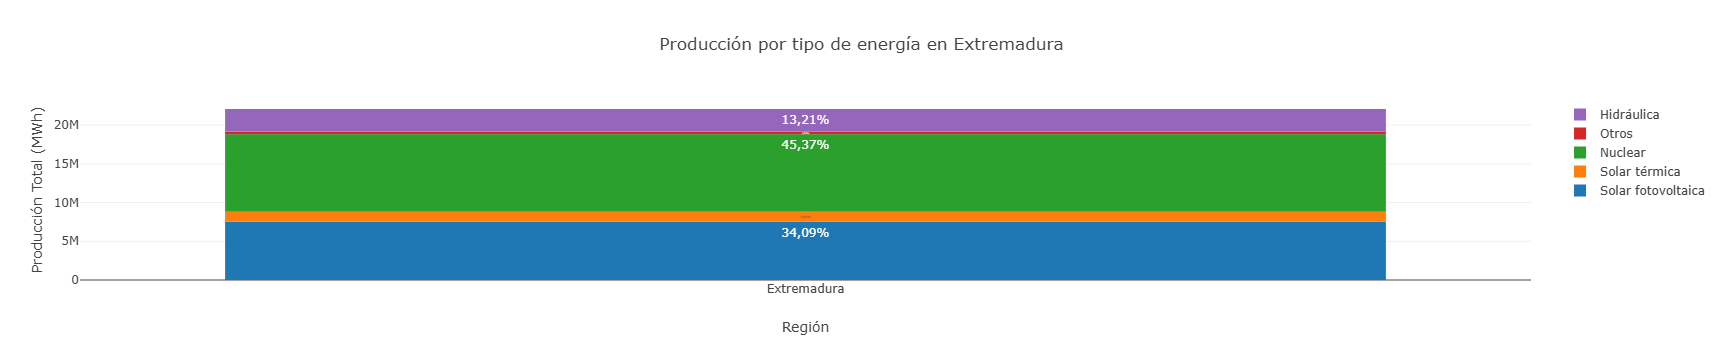

In [9]:
graficoBarrasApiladas(agruparTiposEnergia(acumuladoExtremadura, "Extremadura"), "Extremadura")

In [9]:
import spark.implicits._
// Crear un DataFrame base con todas las combinaciones posibles de regiones y tipos de energía
// Obtener todas las regiones y tipos de energía
val regiones = acumulado.select("Region").distinct().as[String].collect().toSeq
val tiposEnergia = acumulado.select("Tipo").distinct().as[String].collect().toSeq
val combinaciones = for {
    region <- regiones
    tipo <- tiposEnergia
} yield (region, tipo)
val dfBase = combinaciones.toDF("Region", "Tipo")

// Hacer un join con "acumulado" para asegurarnos de que todas las combinaciones estén presentes

val acumulado2 = dfBase
    .join(acumulado, Seq("Region", "Tipo"), "left_outer")
    .na.fill(0, Seq("TotalTipoPorRegion", "PorcentajeSobreTotalRegion"))
    

val ventana = Window.partitionBy("Region")
val acumuladoCompleto = acumulado2
    .withColumn("TotalPorRegion", sum($"TotalTipoPorRegion").over(ventana))
    .withColumn("PorcentajeSobreTotalRegion", round($"TotalTipoPorRegion"/$"TotalPorRegion"*100,2))
    
    
acumuladoCompleto.write
            .mode("overwrite")
            //.option("encoding", "UTF-8")
            //.option("header", "true").csv("data/csv/dsMercadoNacionalTotal.csv")
            .parquet("../../data/parquet/DatosTop5Regiones.parquet")

cmd10.sc:4: not found: value acumulado
val regiones = acumulado.select("Region").distinct().as[String].collect().toSeq
               ^
cmd10.sc:5: not found: value acumulado
val tiposEnergia = acumulado.select("Tipo").distinct().as[String].collect().toSeq
                   ^
Compilation Failed

In [10]:
val DatosTop5Regiones = spark.read
        .parquet("../../data/parquet/DatosTop5Regiones.parquet")

DatosTop5Regiones: DataFrame = [Region: string, Tipo: string ... 3 more fields]

In [11]:
val dfPivot = DatosTop5Regiones
    .groupBy("Region") // Agrupar por región
    .pivot("Tipo") // Convertir los tipos en columnas
    .agg(sum("TotalTipoPorRegion")) // Agregar los valores de producción

dfPivot.show()

+------------------+---------+------------------+------------------+-----------------+-----------------+-----------------+------------------+----------------------+-------------------+------------------+------------------+------------------+
|            Region|   Carbón|   Ciclo combinado|      Cogeneración|           Eólica|       Hidráulica|          Nuclear|  Otras renovables|Residuos no renovables|Residuos renovables|Solar fotovoltaica|     Solar térmica|Turbinación bombeo|
+------------------+---------+------------------+------------------+-----------------+-----------------+-----------------+------------------+----------------------+-------------------+------------------+------------------+------------------+
|       Extremadura|      0.0|               0.0|24159.911999999997|       130691.554|      2916560.939|   1.0017941197E7|          134906.0|                   0.0|                0.0| 7528185.291999999|       1287751.047|         42778.057|
|           Galicia|  -82.581|12

dfPivot: DataFrame = [Region: string, Carbón: double ... 11 more fields]

In [12]:
dataRegiones.orderBy(desc("Fecha")).show()

cmd13.sc:1: not found: value dataRegiones
val res13 = dataRegiones.orderBy(desc("Fecha")).show()
            ^
Compilation Failed

#### Creamos dataframe con datos de población

In [12]:
dfConsulta3.limit(10).select("Region", "Fuente_de_Energía_Predominante").show()

cmd13.sc:1: not found: value dfConsulta3
val res13 = dfConsulta3.limit(10).select("Region", "Fuente_de_Energía_Predominante").show()
            ^
Compilation Failed

In [12]:
def graficoTopRegiones(datosConsulta3: DataFrame): Unit = {
    
    // Extraer los datos del DataFrame
    val regiones = datosConsulta3.select("Region").as[String].collect.toSeq
    val energiaTotal = datosConsulta3.select("Energía_Total_por_Region_millones_MWh").as[Double].collect.toSeq
    val energiaPredominante = datosConsulta3.select("Energía_de_Fuente_Predominante_millones_MWh").as[Double].collect.toSeq

    // Traza para la energía total
    val traceTotal = Bar(
      x = energiaTotal,
      y = regiones,
      name = "Energía Total",
      orientation = Orientation.Horizontal
    )

    // Traza para la energía predominante
    val tracePredominante = Bar(
      x = energiaPredominante,
      y = regiones,
      name = "Fuente Predominante",
      orientation = Orientation.Horizontal
    )

    // Configuración del diseño del gráfico
    val layout = Layout(
      title = "Energía Total y Predominante por Región",
      barmode = BarMode.Group,
      xaxis = Axis(title = "Energía (millones MWh)"),
      yaxis = Axis(title = "Región", automargin = true)
    )

    // Renderizar el gráfico
    plot(Seq(traceTotal, tracePredominante), layout)
}

graficoTopRegiones(dfConsulta3.limit(7))

cmd13.sc:36: not found: value dfConsulta3
val res13_1 = graficoTopRegiones(dfConsulta3.limit(7))
                                 ^
Compilation Failed

In [9]:
def topTipo(df: DataFrame, tipo: String, año: String = ""){
    
    val dfFiltrado = if (año != ""){
        df.filter(date_format($"Fecha", "yyyy") === año)
    } else { 
        df
    }
    
    val dfFinal = dfFiltrado.filter($"Tipo" === tipo)
        .groupBy($"Region")
        .agg(sum("Valor").as("ValorTotal"))
        .orderBy(desc("ValorTotal"))
        .withColumn("Valor total Region (millones MWh)", round(col("ValorTotal") / 1e6, 2))
        .limit(5)
    
    val valores = dfFinal.select(col("ValorTotal")).as[Double].collect.toSeq
    val regiones = dfFinal.select(col("Region")).as[String].collect.toSeq
    
    val traceTotal = Bar(
      x = regiones,
      y = valores,
      name = "Generación total",
    )
    val layout = Layout(
      title = "Top 3 regiones en energia " + tipo,
    )
    plot(Seq(traceTotal), layout)
    
    
}

//topHidraulica.show()

defined function topTipo

In [ ]:
def top5ProduccionPorRegion(df: DataFrame): Unit = {

    val df2024 = df
        .filter(date_format($"Fecha", "yyyy") === "2024") // Filtrar solo el año 2024

    // Obtener el total de energía generada por cada región
    val totalPorRegion = df2024
        .groupBy("Region")
        .agg(sum("Valor").as("TotalGenerado"))
        .orderBy(desc("TotalGenerado"))
        .limit(5) // Tomar las 5 regiones con mayor producción

    // Filtrar solo esas 5 regiones en el DataFrame original
    val dfTop5 = df2024.join(totalPorRegion, Seq("Region"), "inner")

    // Calcular el porcentaje de cada tipo de energía dentro de su región
    val dfConPorcentaje = dfTop5
        .groupBy("Region", "Tipo")
        .agg(sum("Valor").as("ValorTotal"))
        .join(totalPorRegion, Seq("Region"))
        .withColumn("Porcentaje", round(col("ValorTotal") / col("TotalGenerado") * 100, 2))
        .orderBy(desc("TotalGenerado"))

    // Obtener las 5 regiones en orden
    val regiones = dfConPorcentaje.select("Region").distinct().as[String].collect.toSeq

    // Obtener los tipos de energía dentro de esas regiones
    val tiposEnergia = dfConPorcentaje.select("Tipo").distinct().as[String].collect.toSeq

    // Crear las trazas para cada tipo de energía
    val traces = tiposEnergia.map { tipo =>
        val datosTipo = dfConPorcentaje.filter($"Tipo" === tipo)
        val valores = datosTipo.select("ValorTotal").as[Double].collect.toSeq
        val porcentajes = datosTipo.select("Porcentaje").as[Double].collect.toSeq.map(p => f"$p%.2f%%")

        Bar(
            x = regiones,
            y = valores,
            name = tipo,
            text = porcentajes,
            hoverinfo = HoverInfo.Text
        )
    }

    // Layout del gráfico
    val layout = Layout(
        title = "Top 5 Regiones con Mayor Producción en 2024",
        barmode = BarMode.Stack,
        xaxis = Axis(title = "Región"),
        yaxis = Axis(title = "Producción Total (MWh)")
    )

    val data = traces
    plot(data, layout)
}

// Ejecutar la función
top5ProduccionPorRegion(dataRegiones)


run at ThreadPoolExecutor.java:1149

16 / 16

run at ThreadPoolExecutor.java:1149

200 / 200

run at ThreadPoolExecutor.java:1149

200 / 200

run at ThreadPoolExecutor.java:1149

1 / 1

run at ThreadPoolExecutor.java:1149

1 / 1

collect at cmd2.sc:25

16 / 16

collect at cmd2.sc:25

200 / 200

collect at cmd2.sc:25

200 / 200

collect at cmd2.sc:25

6 / 6

collect at cmd2.sc:25

200 / 200

run at ThreadPoolExecutor.java:1149

16 / 16

run at ThreadPoolExecutor.java:1149

16 / 16

run at ThreadPoolExecutor.java:1149

200 / 200

run at ThreadPoolExecutor.java:1149

1 / 1

run at ThreadPoolExecutor.java:1149

200 / 200

run at ThreadPoolExecutor.java:1149

1 / 1

collect at cmd2.sc:28

16 / 16

collect at cmd2.sc:28

200 / 200

collect at cmd2.sc:28

200 / 200

collect at cmd2.sc:28

6 / 6

collect at cmd2.sc:28

200 / 200

run at ThreadPoolExecutor.java:1149

16 / 16

run at ThreadPoolExecutor.java:1149

16 / 16

run at ThreadPoolExecutor.java:1149

200 / 200

run at ThreadPoolExecutor.java:1149

1 / 1

run at ThreadPoolExecutor.java:1149

200 / 200

run at ThreadPoolExecutor.java:1149

1 / 1

collect at cmd2.sc:33

16 / 16

collect at cmd2.sc:33

200 / 200

collect at cmd2.sc:33

200 / 200

collect at cmd2.sc:33

2 / 2

run at ThreadPoolExecutor.java:1149

16 / 16

run at ThreadPoolExecutor.java:1149

16 / 16

run at ThreadPoolExecutor.java:1149

200 / 200

run at ThreadPoolExecutor.java:1149

1 / 1

run at ThreadPoolExecutor.java:1149

200 / 200

run at ThreadPoolExecutor.java:1149

1 / 1

collect at cmd2.sc:34

16 / 16

collect at cmd2.sc:34 
 (kill)

0 + 11 / 200

In [13]:
dataRegiones
    .filter($"Compuesto" === false) 
            .filter($"Familia" =!= "Demanda")
    .filter($"Region".isin("Extremadura", "Cataluña"))
    .withColumn("Año", date_format($"Fecha", "yyyy"))
    .groupBy($"Año", $"Region")
    .agg(sum("Valor").as("ValorTotal"))
    .orderBy(desc("Año"))
    .show()

show at cmd12.sc:6

16 / 16

show at cmd12.sc:6

16 / 16

show at cmd12.sc:6

200 / 200

show at cmd12.sc:6

200 / 200

+----+-----------+--------------------+
| Año|     Region|          ValorTotal|
+----+-----------+--------------------+
|2024|   Cataluña| 8.427864425199999E7|
|2024|Extremadura|2.8539073307999995E7|
|2023|   Cataluña|1.2658578553400007E8|
|2023|Extremadura|3.9309771191999994E7|
|2022|Extremadura| 3.592534191699997E7|
|2022|   Cataluña|1.3140857622600004E8|
|2021|   Cataluña|1.2931842247899994E8|
|2021|Extremadura|3.4797881743999995E7|
|2020|   Cataluña|1.3107212024199995E8|
|2020|Extremadura| 3.125801858499998E7|
|2019|Extremadura|3.0964993840999983E7|
|2019|   Cataluña|1.3925793101199996E8|
|2018|   Cataluña|     1.37241891229E8|
|2018|Extremadura|3.1124809127999987E7|
|2017|   Cataluña|1.4041673465700004E8|
|2017|Extremadura|      3.1218206183E7|
|2016|   Cataluña|1.3678366292199996E8|
|2016|Extremadura|3.0908782925999995E7|
|2015|   Cataluña|     1.36163778806E8|
|2015|Extremadura| 3.072430811000001E7|
+----+-----------+--------------------+
only showing top 20 rows



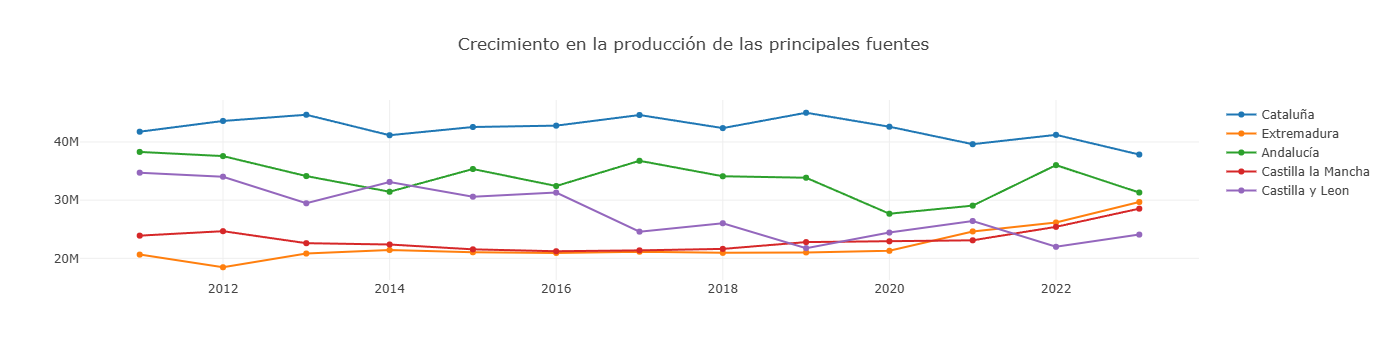

defined function AnalisisEvolucionProduccionReginal
Regiones: Seq[String] = List(
  "Cataluña",
  "Extremadura",
  "Andalucía",
  "Castilla la Mancha",
  "Castilla y Leon"
)

In [25]:
def AnalisisEvolucionProduccionReginal(listaRegiones: Seq[String], df: DataFrame): Unit = {

    val dfAgrupado = df
            .filter($"Compuesto" === false) 
            .filter($"Familia" =!= "Demanda")
            .withColumn("Año", date_format($"Fecha", "yyyy"))
            .filter($"Año" =!= "2024")
            .groupBy($"Region", $"Año")
            .agg(sum("Valor").as("ValorTotal"))
    
    val listaDFRegiones = listaRegiones.map(Region => dfAgrupado.filter(col("Region") === Region).orderBy("Año"))                                 
    val seqFechas = listaDFRegiones.head.select("Año").as[String].collect.toSeq
    val seqValores = listaDFRegiones.map(dfRegion => dfRegion.select("ValorTotal").as[Double].collect.toSeq)

    val traces = listaRegiones.zip(seqValores).map { case (nombre, seqValor) =>
    Scatter(seqFechas, seqValor, name = nombre)
    }
    val layout = Layout(title = "Crecimiento en la producción de las principales fuentes")
    val data = traces
    plot(data, layout)
}

val Regiones = Seq("Cataluña","Extremadura", "Andalucía", "Castilla la Mancha", "Castilla y Leon")
AnalisisEvolucionProduccionReginal(Regiones, datosRegionesMensual)

In [20]:
datosRegionesMensual.groupBy(date_format($"Fecha", "yyyy").as("Año")).count().orderBy("Año").show()

+----+-----+
| Año|count|
+----+-----+
|2011| 2978|
|2012| 2975|
|2013| 2948|
|2014| 2977|
|2015| 2997|
|2016| 3002|
|2017| 2999|
|2018| 2986|
|2019| 2998|
|2020| 2987|
|2021| 2975|
|2022| 2978|
|2023| 2989|
|2024| 2201|
+----+-----+

